In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 10 07:29:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parameter import Parameter

import math
import tqdm

from sklearn import preprocessing

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTEENN

import collections

# Preparing Data

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def findscam(s):
  scam = pd.read_csv(f"/content/drive/MyDrive/IS/spider/scamid.txt")
  ls_scam = scam['scam_id'].values.tolist()

  node_labels = []

  for j in s[:]:
    if j in ls_scam:
      node_labels.append(int(1))
    else:
      node_labels.append(int(0))

  return node_labels

##Transaction

In [4]:
df_txn = pd.read_csv("/content/drive/MyDrive/IS/data/txn1_cleaned.csv")
df_txn.info()
df_txn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29823 entries, 0 to 29822
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   29823 non-null  int64  
 1   TxHash       29823 non-null  object 
 2   BlockHeight  29823 non-null  float64
 3   TimeStamp    29823 non-null  float64
 4   From         29823 non-null  object 
 5   To           29823 non-null  object 
 6   Value        29823 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.6+ MB


,Unnamed: 0,TxHash,BlockHeight,TimeStamp,From,To,Value
0,0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095.0,1.529874e+09,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000
1,1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181.0,1.529875e+09,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020
2,2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716.0,1.529883e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390
3,3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038.0,1.529888e+09,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800
4,4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437.0,1.529893e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506


In [5]:
df_txn = df_txn.drop(columns = ['Unnamed: 0', 'TxHash', 'BlockHeight'])
df_txn.info()
df_txn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29823 entries, 0 to 29822
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  29823 non-null  float64
 1   From       29823 non-null  object 
 2   To         29823 non-null  object 
 3   Value      29823 non-null  float64
dtypes: float64(2), object(2)
memory usage: 932.1+ KB


,TimeStamp,From,To,Value
0,1.529874e+09,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000
1,1.529875e+09,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020
2,1.529883e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390
3,1.529888e+09,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800
4,1.529893e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506


In [6]:
df_txn2 = pd.read_csv("/content/drive/MyDrive/IS/data/txn2_cleaned.csv")
df_txn2.info()
df_txn2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11414 non-null  int64  
 1   TxHash      11414 non-null  object 
 2   TimeStamp   11414 non-null  float64
 3   From        11414 non-null  object 
 4   To          11414 non-null  object 
 5   Value       11414 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 535.2+ KB


,Unnamed: 0,TxHash,TimeStamp,From,To,Value
0,0,0x3194c20f3af0b87bbf174aff81ae9c9f94f44e864b3a...,1.524045e+09,0xb2930b35844a230f00e51431acae96fe543a0347,0x00444dc88c43ca9553ee2b522890e1a2ed97c2c7,0.210795
1,1,0x15074ffa4cfe2924442c4bcb420d26c631410cf70ba9...,1.524797e+09,0x00444dc88c43ca9553ee2b522890e1a2ed97c2c7,0x2ede4eb0fe6ca583b5cf9fdc5c100ecea119da7d,0.209535
2,2,0x599d47809d80c70d92a5609cf04d75f098fbfe631fac...,1.589441e+09,0x8a7e7a63b401293c4be78769750622b2a6f33494,0x005b9f4516f8e640bbe48136901738b323c53b00,0.010000
3,3,0x9523f2e8c390f99854570451f46042f41943c7959a1c...,1.525174e+09,0x16c26eb6051fe13273c634cb6df70a26befa9ec3,0x021cfae057e21ed01dd34345b4dc5177ffb5ecfe,0.001502
4,4,0x8f1f281aeb106a104c8e39acf8b9bc6b7cc0150572b8...,1.524673e+09,0x1dc9ec2c5559bacd8952b67717f967d275e40c7c,0x02719431955c049cdd402322acfae1808658c92a,4.678526


In [7]:
df_txn2 = df_txn2.drop(columns = ['Unnamed: 0', 'TxHash'])
df_txn2.info()
df_txn2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  11414 non-null  float64
 1   From       11414 non-null  object 
 2   To         11414 non-null  object 
 3   Value      11414 non-null  float64
dtypes: float64(2), object(2)
memory usage: 356.8+ KB


,TimeStamp,From,To,Value
0,1.524045e+09,0xb2930b35844a230f00e51431acae96fe543a0347,0x00444dc88c43ca9553ee2b522890e1a2ed97c2c7,0.210795
1,1.524797e+09,0x00444dc88c43ca9553ee2b522890e1a2ed97c2c7,0x2ede4eb0fe6ca583b5cf9fdc5c100ecea119da7d,0.209535
2,1.589441e+09,0x8a7e7a63b401293c4be78769750622b2a6f33494,0x005b9f4516f8e640bbe48136901738b323c53b00,0.010000
3,1.525174e+09,0x16c26eb6051fe13273c634cb6df70a26befa9ec3,0x021cfae057e21ed01dd34345b4dc5177ffb5ecfe,0.001502
4,1.524673e+09,0x1dc9ec2c5559bacd8952b67717f967d275e40c7c,0x02719431955c049cdd402322acfae1808658c92a,4.678526


In [8]:
df_txn3 = pd.read_csv("/content/drive/MyDrive/IS/data/txn3_cleaned.csv")
df_txn3.info()
df_txn3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13525 entries, 0 to 13524
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  13525 non-null  int64  
 1   TxHash      13525 non-null  object 
 2   TimeStamp   13525 non-null  float64
 3   From        13525 non-null  object 
 4   To          13525 non-null  object 
 5   Value       13525 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 634.1+ KB


,Unnamed: 0,TxHash,TimeStamp,From,To,Value
0,0,0xa0ab289ce60a48899608f7e8e19e9c453a177dbf1717...,1.519000e+09,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x008edecdaab6007f524140c7e5313c69b8f1fe66,1.994000
1,1,0xe314ddfdb06dc291a83b36e0380ceb16ca00cdd0b0bc...,1.519047e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0x8d5a9460dc761b45ebd2ce21ffccb41c4485267f,1.990000
2,2,0x4380e11afa0bb20ddf4e4d47f4f11bd22fb9eb9a4ef7...,1.520200e+09,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0.062758
3,3,0xc12213d28647b38f4a8a949a261a715dc9ef0d6b8b7a...,1.520200e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0xf230b790e05390fc8295f4d3f60332c93bed42e2,0.000000
4,4,0x79e8208a21c4a2415e5df654212937a59095f70a5720...,1.520201e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0xf230b790e05390fc8295f4d3f60332c93bed42e2,0.000000


In [9]:
df_txn3 = df_txn3.drop(columns = ['Unnamed: 0', 'TxHash'])
df_txn3.info()
df_txn3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13525 entries, 0 to 13524
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  13525 non-null  float64
 1   From       13525 non-null  object 
 2   To         13525 non-null  object 
 3   Value      13525 non-null  float64
dtypes: float64(2), object(2)
memory usage: 422.8+ KB


,TimeStamp,From,To,Value
0,1.519000e+09,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x008edecdaab6007f524140c7e5313c69b8f1fe66,1.994000
1,1.519047e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0x8d5a9460dc761b45ebd2ce21ffccb41c4485267f,1.990000
2,1.520200e+09,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0.062758
3,1.520200e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0xf230b790e05390fc8295f4d3f60332c93bed42e2,0.000000
4,1.520201e+09,0x008edecdaab6007f524140c7e5313c69b8f1fe66,0xf230b790e05390fc8295f4d3f60332c93bed42e2,0.000000


##ALL

In [10]:
txn_all = pd.concat([df_txn, df_txn2, df_txn3])
txn_all.info()
txn_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54762 entries, 0 to 13524
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  54762 non-null  float64
 1   From       54762 non-null  object 
 2   To         54762 non-null  object 
 3   Value      54762 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.1+ MB


,TimeStamp,From,To,Value
0,1.529874e+09,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000
1,1.529875e+09,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020
2,1.529883e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390
3,1.529888e+09,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800
4,1.529893e+09,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506


In [11]:
DG_all = nx.from_pandas_edgelist(
    df = txn_all,
    source='From',
    target='To',
    edge_attr=True,
    create_using=nx.MultiGraph()
)

# confirm it's correct graph
print(f'Is graph directed: {DG_all.is_directed()}')
print(f'Is multigraph: {DG_all.is_multigraph()}')

# view the first two nodes with edge data
list(DG_all.edges(data=True))[0:2]

Is graph directed: False
Is multigraph: True


[('0x16f209b5332a1b4fa5bf19497ca40154c5db2f85',
  '0x002f0c8119c16d310342d869ca8bf6ace34d9c39',
  {'TimeStamp': 1529873859.0, 'Value': 0.5}),
 ('0x16f209b5332a1b4fa5bf19497ca40154c5db2f85',
  '0x002f0c8119c16d310342d869ca8bf6ace34d9c39',
  {'TimeStamp': 1529873859.0, 'Value': 0.5})]

In [12]:
nodeall_ids = list(DG_all.nodes())

all_features = torch.tensor([[1] for node_id in nodeall_ids], dtype=torch.float32)

all_adj = nx.to_numpy_array(DG_all, nodelist=nodeall_ids, weight='Value')
all_adjacency = preprocessing.normalize(all_adj)

In [13]:
nodeall_to_index = {node: (index) for index, node in enumerate(DG_all.nodes())}

print(nodeall_to_index)

{'0x16f209b5332a1b4fa5bf19497ca40154c5db2f85': 0, '0x002f0c8119c16d310342d869ca8bf6ace34d9c39': 1, '0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b': 2, '0xe892875b87b94c44edf0e91ee9f49d0525fadd83': 3, '0x0681d8db095565fe8a346fa0277bffde9c0edbbf': 4, '0x8a7e7a63b401293c4be78769750622b2a6f33494': 5, '0x2dc5c356b58b4cbb03c8aa0a89eff7cd5adc93c3': 6, '0x81aa713372fa1cd34cbb4ff0c9e9ac4688a25b70': 7, '0x00e01a648ff41346cdeb873182383333d2184dd1': 8, '0x7262640299c804fa75b7c814b840a89899ea6c7b': 9, '0xc32fdc40bc6fa7030b402f5fb158331d4854b043': 10, '0xa3b95e2e1550df8d5f63bbe540abd5b442d81246': 11, '0x379805e181aa49041ea0c859fc10141cc2921a73': 12, '0x5b58a1db52be6210259196a78be144e53e7cc6d4': 13, '0x56b2321324fd4b2a416ef84730228a9d559b30b8': 14, '0xcdd82f10463391ffd769ea9ce4b4a26502b3cec5': 15, '0x68ada143dc21d3a079ee73bb3a10e9ce41449784': 16, '0xd38a48f145e3d695fadda4bc9e1b394b4c692045': 17, '0x7916383f4cf051a09f35aad03b66f1629aea2b04': 18, '0xe012765066411e69f32456cb4bb256f546526124': 19, '0x24a039

14186
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 

Text(0.5, 1.0, 'Checking lmbalance')

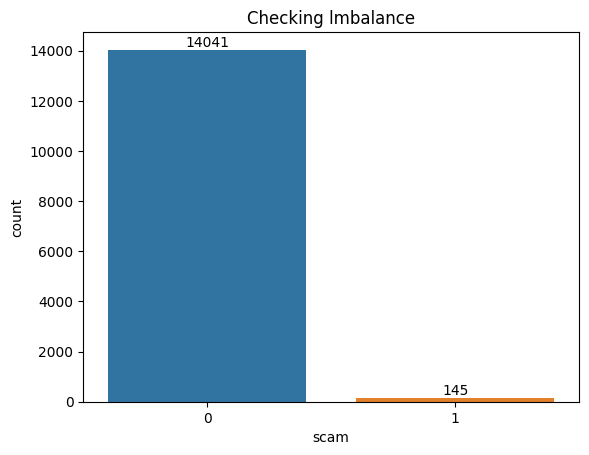

In [14]:
all_labels = findscam(nodeall_ids)

print(f"{len(all_labels)}\n{all_labels}")

lsnode_scams = pd.DataFrame({
    'id':nodeall_ids,
    'scam':all_labels
})

chgr = sns.countplot(data = lsnode_scams, x = 'scam')

for container in chgr.containers:
    chgr.bar_label(container)

plt.title('Checking lmbalance')

#GCN

##Layer

In [24]:
class GCNLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNLayer, self).__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        #init.kaiming_uniform_(self.linear.weight)

    def forward(self, adjacency_matrix, node_features):
        # Perform graph convolution

        x = adjacency_matrix.matmul(node_features)
        #x = self.linear(x)

        return x

In [25]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bias=True):
        super(GCN, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer(input_dim, hidden_dim))

        for _ in range(num_layers - 1):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim))
        self.final_layer = GCNLayer(hidden_dim, output_dim)

        self.weight = Parameter(torch.FloatTensor(hidden_dim, output_dim))
        if bias:
            self.bias = Parameter(torch.FloatTensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, adjacency_matrix, node_features):
        x = node_features
        for layer in self.layers:
            x = F.relu(layer(adjacency_matrix, x))

        x = self.final_layer(adjacency_matrix, x)
        x = F.relu(x)

        if self.bias is not None:
            return x + self.bias
        else:
            return x

##Train

In [26]:
# Create a GCN model

input_dim = all_features.shape[1]
hidden_dim = 128
output_dim = 128
num_layers = 2

embeddings = GCN(input_dim, hidden_dim, output_dim, num_layers)


In [27]:
all_adjacency = torch.tensor(all_adjacency, dtype=torch.float32)

<ipython-input-27-2cf0881e8dd7>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_adjacency = torch.tensor(all_adjacency, dtype=torch.float32)


In [28]:
output = embeddings(all_adjacency, all_features)

In [29]:
print(output)

tensor([[5.8668, 5.9637, 5.8970,  ..., 5.8654, 5.8961, 5.8931],
        [3.4133, 3.5103, 3.4436,  ..., 3.4120, 3.4427, 3.4397],
        [2.6123, 2.7093, 2.6426,  ..., 2.6109, 2.6417, 2.6387],
        ...,
        [4.1084, 4.2054, 4.1387,  ..., 4.1070, 4.1378, 4.1348],
        [4.1084, 4.2054, 4.1387,  ..., 4.1070, 4.1378, 4.1348],
        [1.8284, 1.9254, 1.8587,  ..., 1.8270, 1.8578, 1.8548]],
       grad_fn=<AddBackward0>)


In [30]:
x = output.detach().numpy()
x = np.array(x)
y = all_labels

In [31]:
df = pd.DataFrame(x, index=nodeall_ids)

In [32]:
vec = '/content/drive/MyDrive/IS/data/vecs_gcn.csv'
df.to_csv(vec)